[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img src="Data/Data_flow.svg"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [2]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########
loaded_timestamp = '2022-05-16-19:33:50'

In [3]:
laptop = False
calculate_weights = False
tsne = False

leeds  = False
madrid = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = not laptop
other_models = True

In [4]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# train_nn = not laptop

In [5]:
# import itertools
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# palette = itertools.cycle(sns.color_palette('deep'))

# times  = pd.DataFrame()
# model_time = pd.DataFrame({'city': ['madrid']*4, 'model': ['knn', 'conv1d', 'conv2d', 'nb'], 'time': [15, 1, 40, 3]})
# times = times.append(model_time)
# times = times.sort_values('time')

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")


# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Importar Tensorflow

In [6]:
# !pip install tensorflow-addons

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# !nvidia-smi

Found GPU at: /device:GPU:0


2022-05-23 17:15:39.842871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 17:15:39.892995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:40.073903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:40.074775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Importador/Exportador JSON

In [9]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [10]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [11]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [12]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [13]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Serious:', (Y_oversampled == 'Serious').sum())
    print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [14]:
def build_gray_images(dataset, max_dimension, matrix_indexes):

    matrix_3d = np.zeros((max_dimension, max_dimension, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

In [15]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.3, 0.3],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-6, 6],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-7, 7],
                                                'round': 1
                                   }
                          }
number_of_individuals = 50
numberOfParentsMating = 15
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [16]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [17]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [18]:
from xgboost import XGBClassifier
import xgboost as xgb
import time



def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
               'tree_method': tree_method,
               'single_precision_histogram': True,
               'num_class': 3
             }

    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()


        xgb.set_config(verbosity=0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5

        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Selección de padres

In [19]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [20]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [21]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [22]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## One-Hot Encoder/Decoder

In [23]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Serious': 1,
        'Fatal': 2
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 3)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Serious',
        2: 'Fatal'
    }   

    return Y_labels.replace(transf)

## Visualización de datos

### Matriz de correlación

In [24]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [25]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [27]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [28]:
import tensorflow_addons as tfa

lr_init = 0.1
num_classes = 3

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3,strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())  
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

2022-05-23 17:15:43.449535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:43.449812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:43.449999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:43.450432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 17:15:43.450630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## TASP-CNN

In [29]:
lr_init = 0.1
num_classes = 3

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.Dense(units=128))
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [30]:
tasp_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 256)         2560      
                                                                 
 batch_normalization_4 (Batc  (None, 5, 5, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 256)         590080    
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 256)         590080    
                                                                 
 batch_normalization_6 (Batc  (None, 5, 5, 256)       

In [31]:
print('Done!')

Done!


## Results

### F1-Score History

In [32]:
def plot_f1_score_history(f1_score_path, f1_score_name, history):
    figure_name = plt.figure(figsize=(20, 10))

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [33]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):

    labels = one_hot_to_casualty(y_true)

    report = classification_report(y_true,
                                   y_predicted,
                                   target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [35]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

# Leeds Data

## Importación de datos

In [ ]:
# !conda install pandas --y

In [ ]:
import pandas as pd
# https://datamillnorth.org/dataset/road-traffic-accidents
# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/TFM_DATA/'

city_name = 'leeds'
city = leeds

root_path = './Data/Leeds/'

file_path_2009 = './2009.csv'
file_path_2010 = './2010.csv'
file_path_2011 = './2011.csv'
file_path_2012 = './2012.csv'
file_path_2013 = './2013.csv'
file_path_2014 = './2014.csv'
file_path_2015 = './2015.csv'
file_path_2016 = './2016.csv'

file_2009 = pd.read_csv(root_path + file_path_2009, encoding = 'cp1252')
file_2010 = pd.read_csv(root_path + file_path_2010, encoding = 'cp1252')
file_2011 = pd.read_csv(root_path + file_path_2011, encoding = 'cp1252')
file_2012 = pd.read_csv(root_path + file_path_2012, encoding = 'cp1252')
file_2013 = pd.read_csv(root_path + file_path_2013, encoding = 'cp1252')
file_2014 = pd.read_csv(root_path + file_path_2014, encoding = 'cp1252')
file_2015 = pd.read_csv(root_path + file_path_2015, encoding = 'cp1252')
file_2016 = pd.read_csv(root_path + file_path_2016, encoding = 'cp1252')

###################### UNIÓN DE ARCHIVOS ######################

a = pd.concat([file_2009,file_2010])

file_2013 = clean_df = file_2013.loc[:, ~file_2013.columns.isin(['Casualty Class'])]
file_2013.set_axis(a.columns, axis=1, inplace=True)
                                             
file_2014 = clean_df = file_2014.loc[:, ~file_2014.columns.isin(['Casualty Class'])]
file_2014.set_axis(a.columns, axis=1, inplace=True)

# file_2015 = clean_df = file_2015.loc[:, ~file_2015.columns.isin(['Casualty Class'])]
file_2015.set_axis(a.columns, axis=1, inplace=True)
file_2016 = clean_df = file_2016.loc[:, ~file_2016.columns.isin(['Expr1'])]
file_2016.set_axis(a.columns, axis=1, inplace=True)

a = pd.concat([a, file_2011])
a = pd.concat([a, file_2012])
a = pd.concat([a, file_2013])
a = pd.concat([a, file_2014])
a = pd.concat([a, file_2015])
a = pd.concat([a, file_2016])

# a['1st Road Class'].value_counts()

## Limpieza de datos

In [ ]:
###################### DICCIONARIOS DE REEMPLAZO ######################
# Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# A, A(M) y Motorway lo mismo?
# B:            De carácter regional y utilizado para conectar zonas de menor importancia.
#               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
#               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
#               ¿Carretera como tal?

# C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
#               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.
road_class_replace = {
    'Motorway': 1,
    'A(M)': 2,
    'A': 3,
    'B': 4,
    'C': 5,
    'Unclassified': 6
}

##################################
accident_date_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost / Ice': 4,
    'Flood': 5,
}
##################################

road_surface_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost/ Ice': 4,
    'Frost / Ice': 4,
    'Flood': 5,
    'Flood (surface water over 3cm deep)': 5,
    '5': 5
}

# La 5: "Darkness: street lighting unknown" no está presente en el paper, le hemos puesto un 5 porque sí #
lighting_conditions_replace = {
    'Daylight: street lights present': 1,
    'Darkness: no street lighting': 2,
    'Darkness: street lights present and lit': 3,
    'Darkness: street lights present but unlit': 4,
    'Darkness: street lighting unknown': 5,
    '5': 5
}

# La 8.2: "Unknown" no está presente en el paper, le hemos puesto un 8 porque sí (Other) #
weather_conditions_replace = {
    'Fine without high winds': 1,
    'Raining without high winds': 2,
    'Snowing without high winds': 3,
    'Fine with high winds': 4,
    'Raining with high winds': 5,
    'Snowing with high winds': 6,
    'Fog or mist – if hazard': 7,
    'Other': 8,
    'Unknown': 8
}

type_of_vehicle_replace = {
    'Pedal cycle': 1,
    'M/cycle 50cc and under': 2,
    'Motorcycle over 50cc and up to 125cc': 3,
    'Motorcycle over 125cc and up to 500cc': 4,
    'Motorcycle over 500cc': 5,
    'Taxi/Private hire car': 6,
    'Car': 7,
    'Minibus (8 – 16 passenger seats)': 8,
    'Bus or coach (17 or more passenger seats)': 9,
    'Ridden horse': 10,
    'Agricultural vehicle (includes diggers etc.)': 11,
    'Tram / Light rail': 12,
    'Goods vehicle 3.5 tonnes mgw and under': 13,
    'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw': 14,
    'Goods vehicle 7.5 tonnes mgw and over': 15,
    'Mobility Scooter': 16,
    'Other Vehicle ': 17,
    'Motorcycle - Unknown CC': 18
}

casualty_class_replace = {
    'Driver': 1,
    'Driver/Rider': 1,
    'Driver or rider': 1,
    'Passenger': 2,
    'Vehicle or pillion passenger': 2,
    'Pedestrian': 3
}


sex_of_casualty_replace = {
    'Male': 1,
    'Female': 2
}

###################### REEMPLAZOS ######################
clean_df = clean_df.dropna()

a['1st Road Class'].replace(road_class_replace, inplace = True)
# print('1st Road Class:', a['1st Road Class'].unique())

##################################
# a['Accident Date'].replace(accident_date_replace, inplace = True)
# print('Accident Date:', a['Accident Date'].unique())
##################################
a['Road Surface'].replace(road_surface_replace, inplace = True)
a.dropna(inplace = True)

a['Road Surface'] = a['Road Surface'].astype('int')
# print('Road Surface:', a['Road Surface'].unique())

a['Lighting Conditions'].replace(lighting_conditions_replace, inplace = True)
# print('Lighting Conditions:', a['Lighting Conditions'].unique())

a['Weather Conditions'].replace(weather_conditions_replace, inplace = True)
a = a[a['Weather Conditions'] != 'Darkness: street lighting unknown']
# print('Weather Conditions:', a['Weather Conditions'].unique())

a['Type of Vehicle'].replace(type_of_vehicle_replace, inplace = True)
# print('Type of Vehicle:', a['Type of Vehicle'].unique())

a['Casualty Class'].replace(casualty_class_replace, inplace = True)
# print('Casualty Class:', a['Casualty Class'].unique())

a['Sex of Casualty'].replace(sex_of_casualty_replace, inplace = True)
# print('Sex of Casualty:', a['Sex of Casualty'].unique())

a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] < 18, 1)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(18, 25), 2)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(25, 65), 3)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] > 65, 4)
# print('Age of Casualty:', a['Age of Casualty'].unique())

a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] < 600, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] > 1800, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'].between(600, 1800), 1)
# print('Time (24hr):', a['Time (24hr)'].unique())
a.rename(columns={"Time (24hr)": "Accident Time"}, inplace = True)

###################### LIMPIEZA DE VALORES NULOS/DUPLICADOS ######################

clean_df = a.loc[:, ~a.columns.isin(['Accident Date', 'Reference Number'])]

clean_df['Weather Conditions'] = clean_df['Weather Conditions'].astype('int')
clean_df['Casualty Class']     = clean_df['Casualty Class'].astype('int')

clean_df = clean_df.drop_duplicates()
clean_df = clean_df.dropna()
clean_df = clean_df.reset_index(drop=True)

clean_df

## Split de datos

In [ ]:
# !conda install scikit-learn --y

In [ ]:
from sklearn.model_selection import train_test_split

Y = clean_df['Casualty Severity']

train, test = train_test_split(clean_df, test_size=0.2, random_state = 1)
X_train = X_train_original = train.loc[:, ~train.columns.isin(['Casualty Severity'])]
Y_train = Y_train_original = train['Casualty Severity']

X_test = test.loc[:, ~test.columns.isin(['Casualty Severity'])]
Y_test = test['Casualty Severity']

### Downsampling

In [ ]:
from sklearn.model_selection import train_test_split

Y = clean_df['Casualty Severity']

from sklearn.utils import resample

slight_data  = test[test['Casualty Severity'] == 'Slight']
serious_data = test[test['Casualty Severity'] == 'Serious']
fatal_data   = test[test['Casualty Severity'] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['Casualty Severity'])]
Y_train_downsampled = downsampled_train['Casualty Severity']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['Casualty Severity'])]
Y_test_downsampled = downsampled_test['Casualty Severity']

In [ ]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [ ]:
# !conda install -c conda-forge imbalanced-learn

In [ ]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)
X_train_downsampled = X_train_downsampled.astype(int)
X_test_downsampled  = X_test_downsampled.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
X_train_downsampled = normalize_data(X_train_downsampled)
X_test_downsampled  = normalize_data(X_test_downsampled)

X_train_original = X_train_original.astype(int)
X_train_original = normalize_data(X_train_original)

## Oversamplig de datos

In [ ]:
print('********** Train Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

print('********** Test **********')
print('Slight: ', (Y_test == 'Slight').sum())
print('Serious:', (Y_test == 'Serious').sum())
print('Fatal:  ', (Y_test == 'Fatal').sum())
print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [ ]:
import xgboost as xgb
import random

if calculate_weights:
    Y_train_downsampled_copy = Y_train_downsampled.copy()
    Y_test_downsampled_copy  = Y_test_downsampled.copy()
    Y_test_copy = Y_test.copy()
    Y_train_copy = Y_train.copy()

    Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled_copy)
    Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled_copy)
    Y_test_onehot  = casualty_to_one_hot(Y_test_copy)
    Y_train_onehot  = casualty_to_one_hot(Y_train_copy)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population


#     if not laptop:

#         import dask.array as da
#         import dask.distributed

#         if __name__ == "__main__":

#             # X and y must be Dask dataframes or arrays
#             X = X_train
#             y = Y_train

#             dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)
#             dtest  = xgb.dask.DaskDMatrix(client, X_test, Y_test)

#     else:

    dtrain = xgb.DMatrix(data  = X_train_downsampled,
                         label = Y_train_downsampled_copy)

    dtest  = xgb.DMatrix(data  = X_test_downsampled, 
                         label = Y_test_downsampled_copy)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test_downsampled_copy)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test_downsampled_copy)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

In [ ]:
if calculate_weights and leeds:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [ ]:
if not calculate_weights:
    FILE_NAME = f"{city_name}_hyperparams_{loaded_timestamp}.json"

    best_hyperparams = load_json(HYPERPARAMS_PATH, FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [ ]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [ ]:
if calculate_weights and leeds:
    FILE_NAME = f"{city_name}_hyperparams_{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, HYPERPARAMS_PATH, FILE_NAME)

### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [ ]:
# FILE_NAME = 'leeds_calculated_weights.json'
FILE_NAME = f"{city_name}_weights_{loaded_timestamp}.json"

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

#### Cálculo de pesos de caracetrísticas

In [ ]:
if calculate_weights and leeds:
    xgboost = XGBClassifier(best_hyperparams,
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)

#### Visualización pesos calculados

In [ ]:
if calculate_weights and leeds:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    for column, weight in zip(X_train.columns,xgboost.feature_importances_):
      print(column, weight)

#### Escritura de pesos de características

In [ ]:
if calculate_weights and leeds:    
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights_{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'leeds_default_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [ ]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [ ]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
train_original_bgi = build_gray_images(X_train_original, 5, matrix_indexes)

test_bgi  = build_gray_images(X_test, 5, matrix_indexes)


pd.DataFrame(train_bgi[:,:,1057])

## Reshape de imágenes

In [ ]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)


train_original_images = shape_images(X_data = X_train_original,
                            gray_images = train_original_bgi)

In [ ]:
plt.gray()
for i in range(0,3):
    plt.figure(figsize=(3, 3))
    plt.imshow(train_bgi[:,:,i])
    # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
    plt.show()

In [ ]:
# image = train_bgi[:,:,0]
# plt.figure(figsize=(6, 6))
# plt.imshow([image.flatten()])
# plt.savefig(f"test.svg",transparent=True, dpi=150)


In [ ]:
# !conda install scikit-image

In [ ]:
# input_shape = (5, 5)

array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

array_train_original_images = np.asarray(train_original_images)

In [ ]:
# !conda install -c conda-forge tensorflow 

In [ ]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## Visualización de datos

In [ ]:
# !conda install seaborn

### Matriz de correlación

In [ ]:
# correlation_matrix(X_test)

### PCA

In [ ]:
# pca(X_train, X_test)

### TSNE

In [ ]:
n_samples = 150
index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [ ]:
# Get same number of class samples from SMOTEII
X_slight_train_tsne  = X_train.loc[index_slight]
X_serious_train_tsne = X_train.loc[index_serious]
X_fatal_train_tsne   = X_train.loc[index_fatal]

X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

Y_slight_train_tsne  = Y_train[index_slight]
Y_serious_train_tsne = Y_train[index_serious]
Y_fatal_train_tsne   = Y_train[index_fatal]

Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [ ]:
n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [ ]:
# Get same number of class samples from original
X_slight_clean_tsne  = X_train_original.loc[index_slight]
X_serious_clean_tsne = X_train_original.loc[index_serious]
X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

Y_slight_clean_tsne  = Y_train_original[index_slight]
Y_serious_clean_tsne = Y_train_original[index_serious]
Y_fatal_clean_tsne   = Y_train_original[index_fatal]

Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [ ]:
if tsne:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_test_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [ ]:
# X_train = array_train_images
# X_test = array_test_images
# X_train_original = array_train_original_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_train_original = X_train_original.reshape(len(array_train_original_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder = autoencoder().fit(X_train, X_train,
#                                 epochs = 100,
#                                 batch_size = 128,
#                                 shuffle = True,
#                                 validation_data = (X_test, X_test))

#### Visualización

In [ ]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # # get decoder output to visualize reconstructed image
# # reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [ ]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
Y_test_onehot  = casualty_to_one_hot(Y_test)

## Models

In [ ]:
Y_test_labels = one_hot_to_casualty(Y_test)

from sklearn.utils import class_weight

pesos = class_weight.compute_class_weight('balanced',
                                          classes = np.unique(Y_train_original),
                                          y = Y_train_original)


print('\nPesos calculados:', pesos, '\n\n')


# Keras espera un diccionario donde la clave sea el número de clase 
# y el valor sea el peso calculado. 
pesos = dict(enumerate(pesos))  

In [ ]:
import pickle

### KNN

In [ ]:
# from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[0]

#### Entrenamiento

In [ ]:
leaf_size = list(range(1,10, 2))
n_neighbors = list(range(1,25, 5))

In [ ]:
# # Create new KNN object
# hyperparameters = dict(leaf_size = leaf_size,
#                        n_neighbors = n_neighbors)

# # Use GridSearch
# knn_2 = KNeighborsClassifier()

# # Fit the model
# clf = GridSearchCV(knn_2,
#                    hyperparameters,
#                    cv = 5)

# knn = clf.fit(X_train, Y_train)

# # Print The value of best Hyperparameters

# best_leaf_size = knn.best_estimator_.get_params()['leaf_size']
# best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

# print('Best leaf_size:', best_leaf_size)
# print('Best n_neighbors:', best_n_neighbors)

# df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

# FILE_NAME = f"{MODEL_NAME}/leeds_{MODEL_TIMESTAMP}.csv"

# df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.pkl"

# # Its important to use binary mode 
# knnPickle = open(MODEL_PATH + MODEL_FILE_NAME, 'wb') 

# # source, destination 
# pickle.dump(knn, knnPickle)

#### Carga de modelo pre-entrenado

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_2022-04-27-21:50:26.pkl"

# # load the model from disk
# loaded_model = pickle.load(open(MODEL_PATH + MODEL_FILE_NAME, 'rb'))

#### Resultados

In [ ]:
# y_true = tf.argmax(Y_test_onehot, axis=1)
# y_predicted = knn.predict(X_test)


# ############## SAVE CLASSIFICATION REPORT ##############
# report = classification_report(y_true,
#                                y_predicted,
#                                target_names = Y_test_labels.unique(),
#                                output_dict = True)

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"leeds_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# report_df = pd.DataFrame(report).transpose()
# report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)


# ############## SAVE CONFUSION MATRIX ##############

# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"leeds_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

# cm = confusion_matrix(y_true,
#                       y_predicted,
#                       labels = Y_test.unique())

# disp = ConfusionMatrixDisplay(confusion_matrix = cm,
#                               display_labels = Y_test_labels.unique()).plot()

# plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

### Convolution 1D

In [ ]:
MODEL_NAME = MODELS_NAME[1]

#### Entrenamiento

In [ ]:
from keras.callbacks import ModelCheckpoint

if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    file_name = '_epoch{epoch:02d}-loss{val_loss:.2f}'
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}_{file_name}.hdf5"
    
    checkpoint = ModelCheckpoint(filepath= MODEL_PATH + MODEL_FILE_NAME, 
                                 monitor = 'val_loss',
                                 verbose = 1, 
                                 save_best_only = True,
                                 mode = 'min')
    callbacks = [checkpoint]

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                 # class_weight = pesos,
                                 batch_size = 128,
                                 epochs = 100,
                                 shuffle = True,
                                 validation_data = (array_test_images, Y_test_onehot))
                                 # callbacks = callbacks)

    # convolution_1d.load_weights(MODEL_FILE_NAME)

    history

#### Escritura del modelo

In [ ]:
if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if not city and not train_nn and not laptop:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = 'leeds_convolution_1d_2022-05-11-08:53:52.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and not laptop:
    Y_predicted = convolution_1d.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

    print("[INFO] evaluating network...")

    REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
    REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

    plot_classification_report(path = REPORT_PATH,
                               file_name = REPORT_NAME,
                               y_true = Y_test,
                               y_predicted = Y_predicted)


    CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
    CONFUSION_MATRIX_NAME = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

    plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
                          file_name = CONFUSION_MATRIX_NAME,
                          y_true = Y_test,
                          y_predicted = Y_predicted)

### Convolution 2D

In [ ]:
MODEL_NAME = MODELS_NAME[2]

#### Entrenamiento

In [ ]:
if city and train_nn:
    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = 128,
                           epochs = 100,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    history

#### Escritura del modelo

In [ ]:
if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = 'leeds_convolution_2d_2022-05-11-08:53:52.h5'
    # MODEL_NAME = 'leeds_2022-04-25-08:30:33.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and not laptop:

    Y_predicted = tasp_cnn.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

    print("[INFO] evaluating network...")

    REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
    REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

    plot_classification_report(path = REPORT_PATH,
                               file_name = REPORT_NAME,
                               y_true = Y_test,
                               y_predicted = Y_predicted)


    CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
    CONFUSION_MATRIX_NAME = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

    plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
                          file_name = CONFUSION_MATRIX_NAME,
                          y_true = Y_test,
                          y_predicted = Y_predicted)

## AutoML

In [ ]:
MODEL_NAME = 'auto_ml'

In [ ]:
# import autokeras as ak
# from tensorflow.keras.datasets import mnist

# # (x_train, y_train), (x_test, y_test) = mnist.load_data()

# clf = ak.ImageClassifier(num_classes = 3,
#                          loss='categorical_crossentropy',
#                          metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
#                          overwrite = True,
#                          tuner= 'bayesian',
#                          max_trials = 20,
#                          max_model_size = 3000000
#                         )
    
# clf.fit(array_train_images,
#         np.asarray(Y_train),
#         epochs = 50,
#         batch_size = 128,
#         validation_data = (array_test_images, np.asarray(Y_test)))

# best_auto_model = clf.export_model()
# print(best_auto_model.summary())

### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# best_auto_model.save(MODEL_PATH + MODEL_FILE_NAME)

# # def myprint(s):
# #     with open(f"{MODEL_PATH}_{MODEL_FILE_NAME}_summary.txt",'w+') as f:
# #         print(s, file=f)

        
# from contextlib import redirect_stdout

# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}_summary.txt"

# # with open(f"{MODEL_PATH}_{MODEL_FILE_NAME}", 'w') as f:

# #     best_auto_model.summary(print_fn=lambda x: f.write(x + '\n'))
# with open(f"{MODEL_PATH}_{MODEL_FILE_NAME}", 'w') as f:
#     with redirect_stdout(f):
#         best_auto_model.summary()
#         f.close()

### Resultados

In [ ]:
# Y_predicted = best_auto_model.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

# F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
# F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

# plot_f1_score(f1_score_path = F1_SCORE_PATH,
#               f1_score_name = F1_SCORE_NAME,
#               history = history)

# print("[INFO] evaluating network...")

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# plot_classification_report(path = REPORT_PATH,
#                            file_name = REPORT_NAME,
#                            y_true = Y_test,
#                            y_predicted = Y_predicted)


# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

# plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
#                       file_name = CONFUSION_MATRIX_NAME,
#                       y_true = Y_test,
#                       y_predicted = Y_predicted)

# Madrid Data

## Importación de datos

- [Web Dataset](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

- [Web documentación](https://datos.madrid.es/FWProjects/egob/Catalogo/Seguridad/Ficheros/Estructura_DS_Accidentes_trafico_desde_2019.pdf)



In [156]:
loaded_timestamp = '2022-05-19-14:52:51'
model_version = '2022-05-17-20:07:36'

In [157]:
import pandas as pd
import random
import seaborn as sns

city_name = 'madrid'
city = madrid

# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'

root_path = './Data/Madrid/'

file_name_2019 = '2019_Accidentalidad.csv'
file_name_2020 = '2020_Accidentalidad.csv'
file_name_2021 = '2021_Accidentalidad.csv'
file_name_2022 = '2022_Accidentalidad.csv'

file_2019 = pd.read_csv(root_path + file_name_2019, sep=';')
file_2020 = pd.read_csv(root_path + file_name_2020, sep=';')
file_2021 = pd.read_csv(root_path + file_name_2021, sep=';')
file_2022 = pd.read_csv(root_path + file_name_2022, sep=';')

# print(len(file_2019[file_2019.cod_lesividad == 4]))
# print(len(file_2020[file_2020.cod_lesividad == 4]))
# print(len(file_2021[file_2021.lesividad == '4']))
# print(len(file_2022[file_2022.lesividad == '4']))

COLUMNS_TO_REMOVE = ['cod_distrito',
                     'tipo_lesividad'
                    ]

data_frame = file_2019
data_frame = pd.concat([data_frame, file_2020])

data_frame.rename(columns={"cod_lesividad": "lesividad"}, inplace = True)
data_frame.rename(columns={"tipo_vehículo": "tipo_vehiculo"}, inplace = True)
data_frame = data_frame.drop(COLUMNS_TO_REMOVE, axis=1)

data_frame = pd.concat([data_frame, file_2021])

data_frame.dropna(subset=['lesividad'], inplace = True)
data_frame.lesividad = data_frame.lesividad.replace(' ', 14).astype(int)
data_frame = data_frame.reset_index(drop=True)

### Calcular Vehículos implicados

A partir del número de expediente (un mismo expediente en varias filas quiere decir que se trata del mismo accidente) se hace un `groupby` a partir de él. Como el atributo `positiva_alcohol` no tiene valores nulos en ninguna de las filas, hacemos un conteo a partir de él y se asigna a una nueva columna `positiva_alcohol_rename` que posteriormente será renombrada como `vehiculos_implicados`

In [158]:
data_frame = data_frame.join(data_frame.groupby('num_expediente')['positiva_alcohol'].count(), on='num_expediente', rsuffix='_rename')
data_frame.rename(columns={"positiva_alcohol_rename": "vehiculos_implicados"}, errors="raise", inplace=True)
data_frame = data_frame.reset_index(drop=True)
# data_frame.localizacion.unique()[:1000]

## Limpieza de datos

### Clasificación de carreteras

In [159]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified


regex = {}
regex['parking'] = 'PK|P.K|parking'
regex['aeropuerto_regex'] = 'AEROPUERTO|AEROP'
regex['cuesta_regex'] = 'CUSTA|CUESTA'
regex['paseo_regex'] = 'PASEO|paseo'
regex['parque_regex'] = 'PARQUE|PQUE|RETIRO'
regex['tunel_regex'] = 'TUNEL|TÚNEL'
regex['poligono_regex'] ='POLIGONO'
regex['camino_regex']= 'CMNO|CAMINO'
regex['ronda_regex'] = 'RONDA'
regex['rotonda_regex'] = 'GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT'
regex['puerta_regex'] = 'PUERTA|PTA|Puerta'
regex['puente_regex'] = 'PNTE|PUENTE'
regex['plaza_regex'] = 'PLAZA|PZA'
regex['bulevard_regex'] = 'BULE'
regex['travesia_regex'] = 'TRVA'
regex['calzada_regex'] = 'CALZADA'
regex['road_regex'] = 'CTRA.|CARRETERA|carretera|CRA.' # B
regex['avenida_regex'] = 'AVDA|AV|AVENIDA|AVDA|avenida|Avda.'
regex['highway_regex'] = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23|KILOMETRO' # A,A(M),Motorway
regex['calle_regex']  = 'CALL.|Calle|CALLE|c/|C/|C.|calle'

data_frame['tipo_via'] = 'N/A'

for index,regex_values in enumerate(regex.values()):
    
    print(regex_values)
    regex_indexes = data_frame[data_frame.localizacion.str.contains(regex_values,  case = True, regex=True)].index
    print(len(regex_indexes))
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('tipo_via')] = str(index)
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('localizacion')] = str(index)
    
    
    
# # street_indexes  = data_frame[data_frame.localizacion.str.contains('CALL.|Calle|CALLE|c/|C/|C.|calle', case = True, regex=True)].index
# # highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# # road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# # data_frame['tipo_via'] = 'N/A'

# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]


PK|P.K|parking
1907
AEROPUERTO|AEROP
157
CUSTA|CUESTA
237
PASEO|paseo
5677
PARQUE|PQUE|RETIRO
265
TUNEL|TÚNEL
382
POLIGONO
4
CMNO|CAMINO
838
RONDA
445
GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT
1972
PUERTA|PTA|Puerta
93
PNTE|PUENTE
148
PLAZA|PZA
2416
BULE
82
TRVA
102
CALZADA
626
CTRA.|CARRETERA|carretera|CRA.
942
AVDA|AV|AVENIDA|AVDA|avenida|Avda.
13701
AUTOV.|autovia|A-|M-|M 30|m 30|A\d|M 23|M23|KILOMETRO
3698
CALL.|Calle|CALLE|c/|C/|C.|calle
27146


In [160]:
index_of_assigned_location_values = data_frame[~data_frame.localizacion.str.isnumeric()].index
data_frame.loc[index_of_assigned_location_values, 'localizacion'] = 19

In [161]:
data_frame.localizacion.value_counts()

19    27146
17    13701
3      5677
18     3698
12     2416
9      1972
0      1907
16      942
7       838
15      628
8       445
5       382
4       265
2       237
1       159
11      148
19      124
14      102
10       93
13       82
6         4
Name: localizacion, dtype: int64

In [162]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified
# street_regex  = ('CALL.|Calle|CALLE|c/|C/|C.|calle|'
#                  'AVDA|AV|AVENIDA|AVDA|avenida|Avda.|'
#                  'PASEO|paseo|'
#                  'PARQUE|PQUE|'
#                  'RONDA|'
#                  'PUERTA|PTA|Puerta|'
#                  'PNTE|PUENTE|'
#                  'PLAZA|PZA|'
#                  'CMNO|CAMINO|'
#                  'BULE|'
#                  'TRVA|'
#                  'CUSTA|CUESTA|'
#                  'GTA|gta|GLORIETA|glorieta|ROTONDA|'
#                  'AEROPUERTO|AEROP'
# )

# highway_regex = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# road_regex = 'CTRA.|CARRETERA|carretera|CRA.|CALZADA|POLIGONO' # B

# street_indexes  = data_frame[data_frame.localizacion.str.contains(street_regex,  case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# # positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# # data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

In [163]:
data_frame

,num_expediente,fecha,hora,localizacion,numero,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga,vehiculos_implicados,tipo_via
0,2018S017842,04/02/2019,9:10:00,19,1,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7,440.068.049,4.475.679.170,N,NaN,2,19
1,2018S017842,04/02/2019,9:10:00,19,1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7,440.068.049,4.475.679.170,N,NaN,2,19
2,2019S000002,01/01/2019,3:50:00,19,65,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 21 a 24 años,Hombre,2,436.473.789,4.472.030.489,N,NaN,1,19
3,2019S000006,01/01/2019,8:10:00,19,16,CARABANCHEL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 21 a 24 años,Hombre,14,438.116.128,4.471.171.190,S,NaN,2,19
4,2019S000006,01/01/2019,8:10:00,19,16,CARABANCHEL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 55 a 59 años,Hombre,14,438.116.128,4.471.171.190,N,NaN,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60961,2021S015803,31/08/2021,13:50:00,19,168,USERA,Alcance,Despejado,Turismo,Conductor,De 55 a 59 años,Hombre,14,439279,"4470784,77",N,NaN,3,19
60962,2021S015803,31/08/2021,13:50:00,19,168,USERA,Alcance,Despejado,Turismo,Pasajero,De 35 a 39 años,Mujer,2,439279,"4470784,77",N,NaN,3,19
60963,2021S016898,31/08/2021,22:56:00,7,1,MORATALAZ,Colisión fronto-lateral,Despejado,Motocicleta hasta 125cc,Conductor,De 25 a 29 años,Hombre,7,"443959,86","4473579,83",N,NaN,3,7
60964,2021S016898,31/08/2021,22:56:00,7,1,MORATALAZ,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 25 a 29 años,Mujer,14,"443959,86","4473579,83",N,NaN,3,7


Consideraciones:

- Los patinetes se han considerado como ciclomotres de menos de 50cc.
- Las furgonetas se consideran como vehículos de menos de 3.5 toneladas.
- Maquinaria de obras se considera la misma tipología que maquinaria agrícola.
- Cuadriciclos ligeros y no ligeros se consideran como `Motorcycle-Unknown CC`.
- Patinetes y Vehículos de Mobilidad Urbana se consideran como `Mobility Scooters`.
- `Vehículo articulado` se considera como un vehículo de más de 7.5 toneladas.

In [164]:
weather_conditions_replace = {
    'Despejado': 1,
    'Nublado': 2,
    'Lluvia débil': 3,
    'LLuvia intensa': 4,
    'Granizando':  5,
    'Nevando': 6,
    'Se desconoce': 7 
}

## CUIDADO CON Motocicleta hasta 125cc!!! HEMOS SUPUESTO QUE LOS CICLOMOTORES SON HASTA 50CC!!
type_of_vehicle_replace = {
    'Bicicleta': 1,
    'Ciclo': 1,
    'Bicicleta EPAC (pedaleo asistido)': 1,
    'Ciclomotor': 2,
    'Ciclomotor de dos ruedas L1e-B': 2,
    'Ciclomotor de tres ruedas': 2,
    'Motocicleta hasta 125cc': 3,
    'Moto de tres ruedas hasta 125cc': 3,
    'Motocicleta > 125cc': 4,
    'Moto de tres ruedas > 125cc': 4,
    'Turismo': 5,
    'Todo terreno': 5,
    'Microbús <= 17 plazas': 5,
    'Autobús': 6,
    'Autobus EMT': 6,
    'Autobús articulado': 6,
    'Autobús articulado EMT': 6,
    'Maquinaria agrícola': 7,
    'Maquinaria de obras': 8,
    'Furgoneta': 9,        # Menos de 3.5 toneladas.
    'Ambulancia SAMUR': 10,
    'Autocaravana': 11,     # Entre 3.5 y 7.5 toneladas.
    'Camión rígido': 12,    # Mayor que 7.5 toneladas.
    'Tractocamión': 12,
    'Vehículo articulado': 12,
    'Camión de bomberos': 12,
    'VMU eléctrico': 13,
    'Patinete': 13,
    'Sin especificar': 14,
    'Otros vehículos sin motor': 14,
    'Remolque': 14,
    'Semiremolque': 14,
    'Otros vehículos con motor': 15,
    'Cuadriciclo ligero': 15,
    'Cuadriciclo no ligero': 15,
    'Motorcycle - Unknown CC': 15
}

# type_of_vehicle_replace = {}
# for index,tipo_vehiculo in enumerate(data_frame.tipo_vehiculo.unique()):
#     if not pd.isna(tipo_vehiculo): type_of_vehicle_replace[tipo_vehiculo] = index

casualty_class_replace = {
    'Conductor': 1,
    'Pasajero': 2,
    'Peatón': 3
}

### CUIDADO CON DESCONOCIDO!!! MEJOR HACER IMPUTACIÓN PARA RELLENENAR LOS DESCONOCIDOS?
sex_of_casualty_replace = {
    'Hombre': 1,
    'Mujer': 2,
    'Desconocido': 3
}

accident_type_replace = {
    'Colisión fronto-lateral': 1,
    'Alcance': 2,
    'Colisión lateral': 3,
    'Choque contra obstáculo fijo': 4,
    'Colisión múltiple': 5,
    'Caída': 5,
    'Atropello a persona': 7,
    'Colisión frontal': 8,
    'Otro': 9,
    'Solo salida de la vía': 10,
    'Vuelco': 11,
    'Atropello a animal': 12,
    'Despeñamiento': 13
}

alcohol_replace = {
    'S': 1,
    'N': 2,
}

accident_class_replace = {
    1:  'Slight',  # Atención en urgencias sin posterior ingreso. - LEVE
    2:  'Slight',  # Ingreso inferior o igual a 24 horas - LEVE
    5:  'Slight',  # Asistencia sanitaria ambulatoria con posterioridad - LEVE
    6:  'Slight',  # Asistencia sanitaria inmediata en centro de salud o mutua - LEVE
    7:  'Slight',  # Asistencia sanitaria sólo en el lugar del accidente - LEVE
    14: 'Slight',  # Sin asistencia sanitaria - LEVE O NADA
    3:  'Serious', # Ingreso superior a 24 horas. - GRAVE
    4:  'Fatal'    # Fallecido 24 horas - FALLECIDO 
}
###################### REEMPLAZOS ######################

# ### OJO QUE ESTAMOS REPLICANDO LA ESTRUCTURA DEL DATASET DE LEEDS
age_replace = {
    'Menor de 5 años': 1,
    'De 6 a 9 años': 1,
    'De 6  a  9 años': 1,
    'De 10 a 14 años': 1,
    'De 15 a 17 años': 1,
    'De 18 a 20 años': 2,
    'De 21 a 24 años': 2,
    'De 25 a 29 años': 3,
    'De 30 a 34 años': 3,
    'De 35 a 39 años': 3,
    'De 40 a 44 años': 3,
    'De 45 a 49 años': 3,
    'De 50 a 54 años': 3,
    'De 55 a 59 años': 3,
    'De 60 a 64 años': 3,
    'De 65 a 69 años': 4,
    'De 70 a 74 años': 4,
    'Más de 74 años': 4,
    'Desconocido': 5,
}

# age_replace = {
#     'Menor de 5 años': 1,
#     'De 6 a 9 años': 2,
#     'De 6  a  9 años': 3,
#     'De 10 a 14 años': 4,
#     'De 15 a 17 años': 5,
#     'De 18 a 20 años': 6,
#     'De 21 a 24 años': 7,
#     'De 25 a 29 años': 8,
#     'De 30 a 34 años': 9,
#     'De 35 a 39 años': 10,
#     'De 40 a 44 años': 11,
#     'De 45 a 49 años': 12,
#     'De 50 a 54 años': 13,
#     'De 55 a 59 años': 14,
#     'De 60 a 64 años': 15,
#     'De 65 a 69 años': 16,
#     'De 70 a 74 años': 17,
#     'Más de 74 años': 18,
#     'Desconocido': 19,
# }

data_frame['estado_meteorológico'].replace(weather_conditions_replace, inplace = True)
print('Estado meteorológico: \n', data_frame['estado_meteorológico'].value_counts())

data_frame['tipo_vehiculo'].replace(type_of_vehicle_replace, inplace = True)
print('Tipo vehículo: \n', data_frame['tipo_vehiculo'].value_counts())

data_frame['tipo_persona'].replace(casualty_class_replace, inplace = True)
print('Tipo de persona: \n', data_frame['tipo_persona'].value_counts())

data_frame['sexo'].replace(sex_of_casualty_replace, inplace = True)
print('Sexo: \n', data_frame['sexo'].value_counts())

data_frame['positiva_alcohol'].replace(alcohol_replace, inplace = True)
print('Positivo Alcohol: \n', data_frame['positiva_alcohol'].value_counts())

data_frame['lesividad'].replace(accident_class_replace, inplace = True)
print('Gravedad: \n', data_frame['lesividad'].value_counts())

data_frame['rango_edad'].replace(age_replace, inplace = True)
print('Edad: \n', data_frame['rango_edad'].value_counts())

data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) < '06:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) > '18:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora).between('06:00:00', '18:00:00'), 1)
print('hora:', data_frame['hora'].value_counts())

district_replace = {}
for index,distrito in enumerate(data_frame.distrito.unique()):
  if not pd.isna(distrito): district_replace[distrito] = int(index)

accident_type_replace = {}
for index,accident_type in enumerate(data_frame.tipo_accidente.unique()):
    if not pd.isna(accident_type): accident_type_replace[accident_type] = int(index)

data_frame['distrito'].replace(district_replace, inplace = True)
print('Distrito: \n', data_frame['distrito'].value_counts())

data_frame['tipo_accidente'].replace(accident_type_replace, inplace = True)
print('Tipo Accidente: \n', data_frame['tipo_accidente'].value_counts())

# Eliminamos aquellas lesividades desconocidas i.e. 77.
data_frame = data_frame[data_frame.lesividad != 77]

Estado meteorológico: 
 1.0    50915
3.0     3948
2.0     2942
7.0      919
4.0      804
6.0       81
5.0       18
Name: estado_meteorológico, dtype: int64
Tipo vehículo: 
 5.0     39050
3.0      5655
4.0      4877
9.0      3561
1.0      2154
6.0      1913
2.0      1429
12.0     1188
13.0      513
15.0      396
8.0       115
14.0       43
11.0        9
10.0        2
7.0         1
Name: tipo_vehiculo, dtype: int64
Tipo de persona: 
 1.0    46022
2.0    11409
3.0     3530
Name: tipo_persona, dtype: int64
Sexo: 
 1    40374
2    20348
3      244
Name: sexo, dtype: int64
Positivo Alcohol: 
 2    59616
1     1350
Name: positiva_alcohol, dtype: int64
Gravedad: 
 Slight     59593
Serious     1284
Fatal         84
77             5
Name: lesividad, dtype: int64
Edad: 
 3    47132
2     6859
4     3958
1     2699
5      318
Name: rango_edad, dtype: int64
hora: 1    37079
2    23887
Name: hora, dtype: int64
Distrito: 
 4.0     5189
7.0     4429
19.0    4319
2.0     3930
12.0    3705
14.0    3418


### Coordenadas UTM a números enteros

Las coordenadas UTM son coordenads que están expresadas en término de X e Y partiendo de la base de que parten desde una determinada localización. Estas coordenadas constan de una parte entera y una decimal.

En este dataset el formato que presentan estas coordenadas pueden ser de tres tipos:

- **XXX.XXX.XXX**: en este caso los seis primeros dígitos forman la parte entera y los tres útlimos la parte decimal.
- **XXXXXX,XX**: los seis primeros dígitos indican la parte entera, mientras que tras la coma aparecen dos dígitos de la parte decimal que habrá que completar añadiendo uno más.
- **XXXXXX**: indican la parte entera, sin contar con la parte decimal.

Por lo que el objetivo es estandarizar todos los formatos convirtiendo cada una de las coordenadas a un número entero, siendo necesario tratar con cada una de las casuísticas para añadir ceros a la derecha en caso de que falten para que cada una de las coordenadas tenga la misma longitud.

In [165]:
# Todos las comas a puntos

import re

s = data_frame.coordenada_x_utm.str
s_y = data_frame.coordenada_y_utm.str

# Regex que hace match para dos grupos, la parte entera y la parte decimal.
group_integer_and_float_pattern = '(?P<Integer>\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern   = '(?P<Number>\d{6},\d+)'
all_integer_pattern = '(?P<Number>\d{6}$)'

group_integer_and_float_pattern_y = '(?P<Integer>\d\.\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern_y   = '(?P<Number>\d{7},\d+)'
all_integer_pattern_y = '(?P<Number>\d{7}$)'

# Se extraen en un dataframe independiente ambas partes, la entera y la decimal
index_and_extracted_x1 = s.extract(group_integer_and_float_pattern)
index_and_extracted_x2 = s.extract(all_float_pattern)
index_and_extracted_x3 = s.extract(all_integer_pattern)

index_and_extracted_y1 = s_y.extract(group_integer_and_float_pattern_y)
index_and_extracted_y2 = s_y.extract(all_float_pattern_y)
index_and_extracted_y3 = s_y.extract(all_integer_pattern_y)

# Se seleccionan aquellas que no continenen valores nulos el Float.
# Es decir, aquellos con los que el match ha tenido éxito (los que llevan punto)
# en lugar de comas.
selected_rows_x1 = index_and_extracted_x1[~index_and_extracted_x1['Float'].isnull()]
selected_rows_x2 = index_and_extracted_x2[~index_and_extracted_x2['Number'].isnull()]
selected_rows_x3 = index_and_extracted_x3[~index_and_extracted_x3['Number'].isnull()]

selected_rows_y1 = index_and_extracted_y1[~index_and_extracted_y1['Float'].isnull()]
selected_rows_y2 = index_and_extracted_y2[~index_and_extracted_y2['Number'].isnull()]
selected_rows_y3 = index_and_extracted_y3[~index_and_extracted_y3['Number'].isnull()]

# Se cambia el string de la parte entera a un string sin puntos.
selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
selected_rows_x2.Number  = selected_rows_x2.Number.str.replace(',','.')

selected_rows_y1.Integer = selected_rows_y1.Integer.str.replace('.','')
selected_rows_y2.Number  = selected_rows_y2.Number.str.replace(',','.')

# Se crea una nueva columna en el nuevo dataframe con la unión de la parte
# entera y la parte decimal.
selected_rows_x1['processed_x_utm'] = selected_rows_x1.Integer + selected_rows_x1.Float
selected_rows_x2['processed_x_utm'] = selected_rows_x2.Number
selected_rows_x3['processed_x_utm'] = selected_rows_x3.Number

selected_rows_y1['processed_y_utm'] = selected_rows_y1.Integer + selected_rows_y1.Float
selected_rows_y2['processed_y_utm'] = selected_rows_y2.Number
selected_rows_y3['processed_y_utm'] = selected_rows_y3.Number

data_frame['processed_x_utm'] = 'N/A'
data_frame['processed_y_utm'] = 'N/A'

# Si la longitud de alguno de los números es menor a diez, hay que añadirle x 0s
# de diferencia
selected_rows_x2.processed_x_utm = selected_rows_x2.processed_x_utm.transform(lambda x: x + '0'*(10-len(x)))
selected_rows_x3.processed_x_utm = selected_rows_x3.processed_x_utm.transform(lambda x: x + '.000')

selected_rows_y2.processed_y_utm = selected_rows_y2.processed_y_utm.transform(lambda x: x + '0'*(11-len(x)))
selected_rows_y3.processed_y_utm = selected_rows_y3.processed_y_utm.transform(lambda x: x + '.000')

data_frame['processed_x_utm'][selected_rows_x1.index] = selected_rows_x1['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x2.index] = selected_rows_x2['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x3.index] = selected_rows_x3['processed_x_utm']

data_frame['processed_y_utm'][selected_rows_y1.index] = selected_rows_y1['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y2.index] = selected_rows_y2['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y3.index] = selected_rows_y3['processed_y_utm']

# Eliminamos aquellas filas que no tienen coordenadas
data_frame = data_frame[data_frame['coordenada_y_utm'] != '0.000']

# Eliminamos el punto de la parte decimal para convertirlo a entero
data_frame.processed_x_utm = data_frame.processed_x_utm.str.replace('.','')
data_frame.processed_y_utm = data_frame.processed_y_utm.str.replace('.','')

# Lo convertimos en entero
data_frame.processed_x_utm = data_frame.processed_x_utm.astype(int)
data_frame.processed_y_utm = data_frame.processed_y_utm.astype(int)

/tmp/ipykernel_98712/1802693479.py:38: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_98712/1802693479.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_98712/1802693479.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Renombrado y eliminación de columnas

In [166]:
# COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
# SIN LOCALIZACION COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'localizacion', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm']

data_frame = data_frame.loc[:, ~data_frame.columns.isin(COLUMNS_TO_REMOVE)]

data_frame.rename(columns={"localizacion": "tipo_carretera"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_x_utm": "coordenada_x_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_y_utm": "coordenada_y_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"positiva_alcohol": "drogas_alcohol_positivo"}, errors="raise", inplace=True)

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop=True)

In [167]:
data_frame

,hora,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,drogas_alcohol_positivo,vehiculos_implicados,coordenada_x_utm,coordenada_y_utm
0,1,19,0.0,0,1.0,4.0,1.0,3,1,Slight,2,2,440068049,4475679170
1,1,19,0.0,0,1.0,5.0,1.0,3,2,Slight,2,2,440068049,4475679170
2,2,19,1.0,1,1.0,5.0,1.0,2,1,Slight,2,1,436473789,4472030489
3,1,19,2.0,1,1.0,5.0,1.0,2,1,Slight,1,2,438116128,4471171190
4,1,19,2.0,1,1.0,5.0,1.0,3,1,Slight,2,2,438116128,4471171190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54499,1,19,16.0,4,1.0,5.0,1.0,3,1,Slight,2,3,439279000,4470784770
54500,1,19,16.0,4,1.0,5.0,2.0,3,2,Slight,2,3,439279000,4470784770
54501,2,7,3.0,2,1.0,3.0,1.0,3,1,Slight,2,3,443959860,4473579830
54502,2,7,3.0,2,1.0,5.0,1.0,3,2,Slight,2,3,443959860,4473579830


In [168]:
# X_data_frame = data_frame.loc[:, ~data_frame.columns.isin(['lesividad'])]
# Y_data_frame = data_frame['lesividad']

# X_data_frame  = X_data_frame.astype(int)

## Split de datos

Histograma de desbalanceo

In [169]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data_frame, test_size=0.2, random_state = 2)
X_train = X_train_original = train.loc[:, ~train.columns.isin(['lesividad'])]

X_train = X_train.astype(int)
X_train_original = X_train_original.astype(int)

Y_train = Y_train_original = train['lesividad']

X_test = test.loc[:, ~test.columns.isin(['lesividad'])]
X_test = X_test.astype(int)
Y_test = test['lesividad']

Slight     42509
Serious     1025
Fatal         69
Name: lesividad, dtype: int64

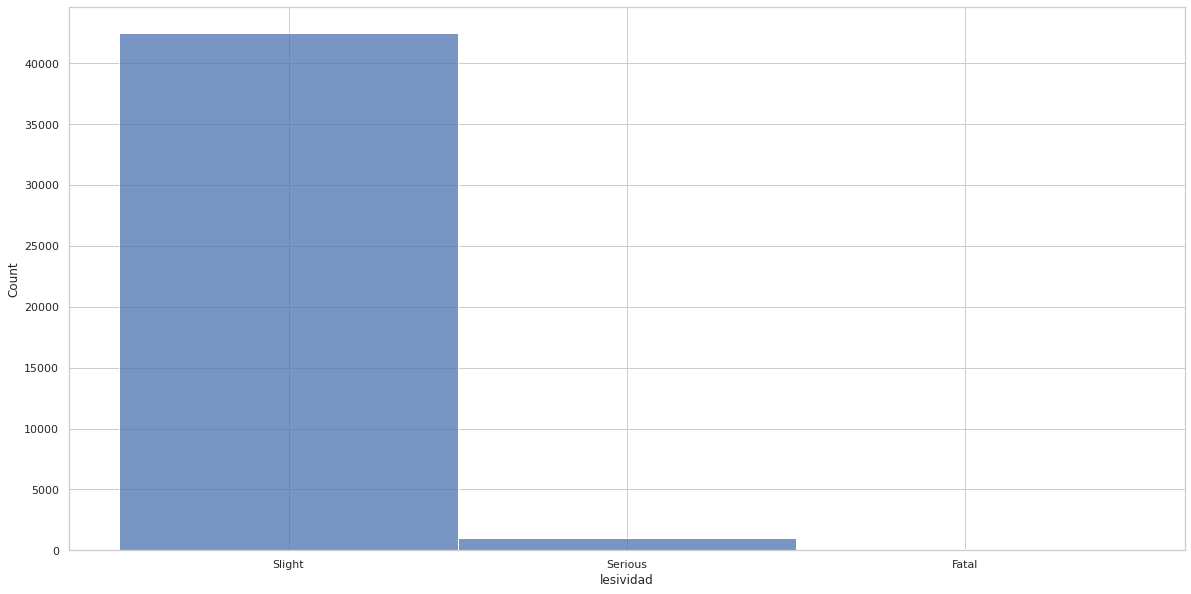

In [170]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/original.svg')
one_hot_to_casualty(Y_train).value_counts()

In [171]:
Y_test.value_counts()

Slight     10640
Serious      246
Fatal         15
Name: lesividad, dtype: int64

In [172]:
# # FILE_NAME = f"{city_name}_calculated_weights.json"
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'

# feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

In [173]:

# feature_vector = {}

# feature_vector['Accident Features'] = {
#     'feature_childs': ['coordenada_x_utm', 'coordenada_y_utm', 'distrito', 'hora', 'vehiculos_implicados'],
#     'feature_weights': [0.165774538, 0.171530785, 0.082228259, 0.047771472, 0.060763375]
# } 

# feature_vector['Roadway Features'] = {
#     'feature_childs': ['tipo_accidente'], # Road Surface 
#     'feature_weights': [0.07036541]
# }

# feature_vector['Environmental Features'] = {
#     'feature_childs': ['estado_meteorológico'],
#     'feature_weights': [0.04354843]
# }

# feature_vector['Vehicle Features'] = {
#     'feature_childs': ['tipo_vehiculo'],
#     'feature_weights': [0.126314657]
# }

# feature_vector['Casualty Features'] = {
#     'feature_childs': ['tipo_persona', 'sexo', 'rango_edad', 'drogas_alcohol_positivo'],
#     'feature_weights': [0.067057589, 0.049116389, 0.095220163, 0.059951354]
# } 
# matrix_indexes = fv2gi(feature_vector)

# # {'Accident Features': {'feature_childs': ['Easting',
# #    'Northing',
# #    '1st Road Class',
# #    'Accident Time',
# #    'Number of Vehicles'],
# #   'feature_weights': [0.165774538,
# #    0.171530785,
# #    0.082228259,
# #    0.047771472,
# #    0.060763375],
# #   'wpi': 0.528068429},
# #  'Roadway Features': {'feature_childs': ['Road Surface'],
# #   'feature_weights': [0.048847406],
# #   'wpi': 0.048847406},
# #  'Environmental Features': {'feature_childs': ['Lighting Conditions',
# #    'Weather Conditions'],
# #   'feature_weights': [0.041826936, 0.04354843],
# #   'wpi': 0.08537536600000001},
# #  'Vehicle Features': {'feature_childs': ['Type of Vehicle'],
# #   'feature_weights': [0.126314657],
# #   'wpi': 0.126314657},
# #  'Casualty Features': {'feature_childs': ['Casualty Class',
# #    'Sex of Casualty',
# #    'Age of Casualty'],
# #   'feature_weights': [0.067057589, 0.049116389, 0.095220163],
# #   'wpi': 0.211394141}}
# feature_vector

## Normalización de datos

In [174]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train_original = X_train_original.astype(int)

X_train = normalize_data(X_train)
X_train_original = normalize_data(X_train_original)
X_test  = normalize_data(X_test)

## Oversampling de datos

In [175]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

********** Before OverSampling **********
Slight:  42509
Serious: 1025
Fatal:   69

 Total X: 43603  Total Y: 43603 

********** After OverSampling **********
Slight:  42509
Serious: 42508
Fatal:   42509

 Total X:  127526  Total Y:  127526 



Slight     42509
Fatal      42509
Serious    42508
Name: lesividad, dtype: int64

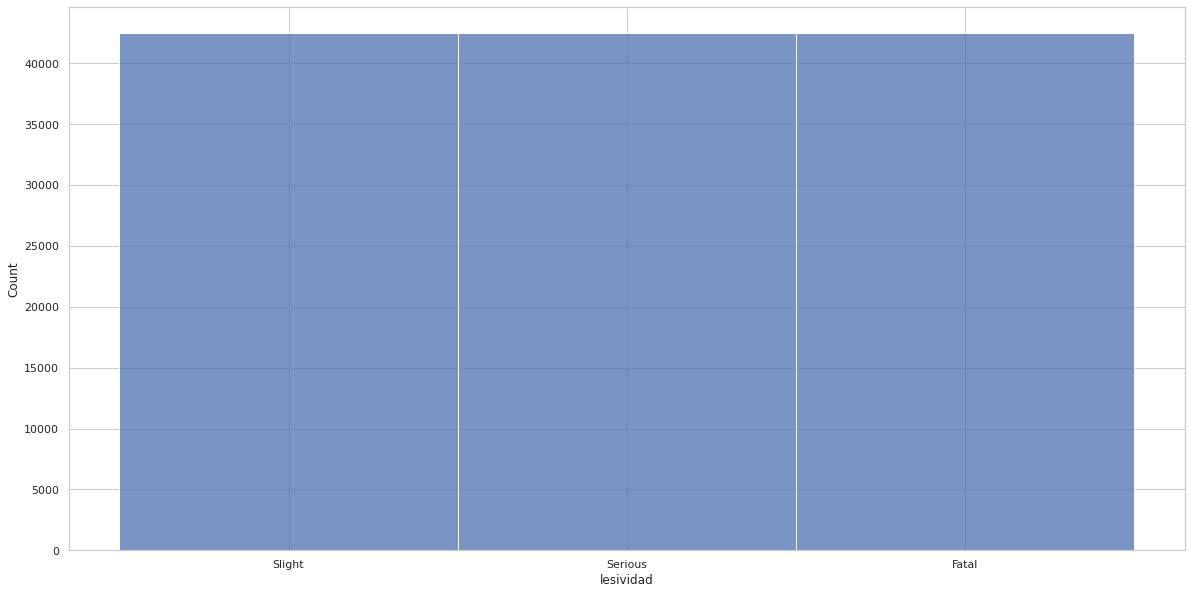

In [176]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/smote-ii.svg')
Y_train.value_counts()

## Downsampling de datos

In [177]:
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

slight_data  = test[test['lesividad'] == 'Slight']
serious_data = test[test['lesividad'] == 'Serious']
fatal_data   = test[test['lesividad'] == 'Fatal']

X_slight_downsampled = resample(slight_data,
                                replace = True,
                                n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))


downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['lesividad'])]
Y_train_downsampled = downsampled_train['lesividad']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['lesividad'])]
Y_test_downsampled = downsampled_test['lesividad']

In [178]:
# plt.figure(figsize=(20, 10))

# sns.set_theme(style="whitegrid")
# sns.histplot(data=one_hot_to_casualty(Y_test_downsampled),stat='count')
# plt.savefig('histograms_images/downsampled-test.svg')
# Y_test_downsampled.value_counts()


# plt.figure(figsize=(20, 10))

# sns.set_theme(style="whitegrid")
# sns.histplot(data=one_hot_to_casualty(Y_train_downsampled),stat='count')
# plt.savefig('histograms_images/downsampled-train.svg')
# Y_train_downsampled.value_counts()

In [179]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train_original = X_train_original.astype(int)

X_train_downsampled = X_train_downsampled.astype(int)
X_test_downsampled  = X_test_downsampled.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
X_train_downsampled = normalize_data(X_train_downsampled)
X_test_downsampled  = normalize_data(X_test_downsampled)

## XGBoost

In [180]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [181]:
if calculate_weights:
    Y_train_downsampled_copy = Y_train_downsampled.copy()
    Y_test_downsampled_copy  = Y_test_downsampled.copy()
    Y_test_copy = Y_test.copy()
    Y_train_copy = Y_train.copy()

    Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled_copy)
    Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled_copy)
    Y_test_onehot  = casualty_to_one_hot(Y_test_copy)
    Y_train_onehot  = casualty_to_one_hot(Y_train_copy)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train,
                         label = Y_train_copy)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test_copy)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test_copy)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test_copy)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.6806, best solution [ 0.9 16.   1. ]
This is number 1 generation
New population is 8
Best F1 score in the this iteration = 0.6825, best solution [ 0.64 14.    0.9 ]
This is number 2 generation
New population is 7
Best F1 score in the this iteration = 0.7075, best solution [0.42 1.   6.6 ]
This is number 3 generation
New population is 15
Best F1 score in the this iteration = 0.7453, best solution [0.15 1.   0.01]
This is number 4 generation
New population is 14
Best F1 score in the this iteration = 0.7453, best solution [0.15 1.   0.01]
This is number 5 generation
New population is 16
Best F1 score in the this iteration = 0.7453, best solution [0.05 1.   6.6 ]
This is number 6 generation
New population is 16
Best F1 score in the this iteration = 0.7453, best solution [0.05 1.   6.6 ]
This is number 7 generation
New population is 22
Best F1 score in the this iteration = 0.7453, best solution [0.05 1. 

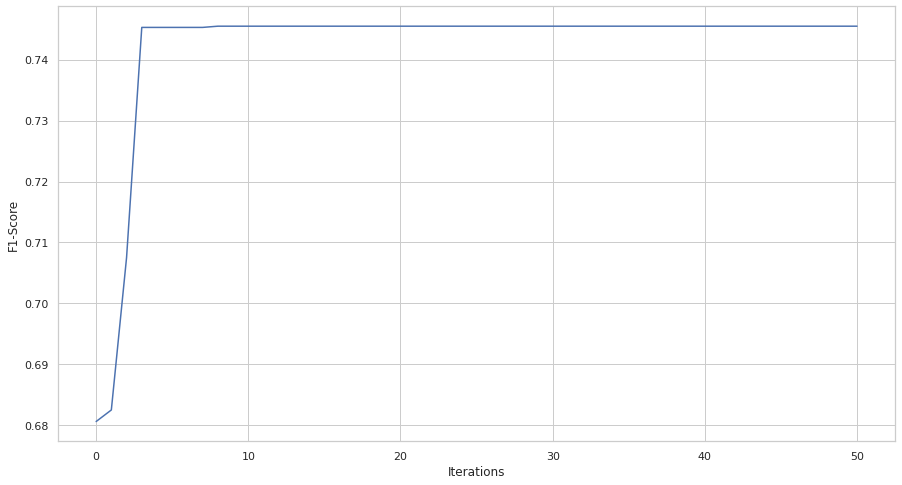

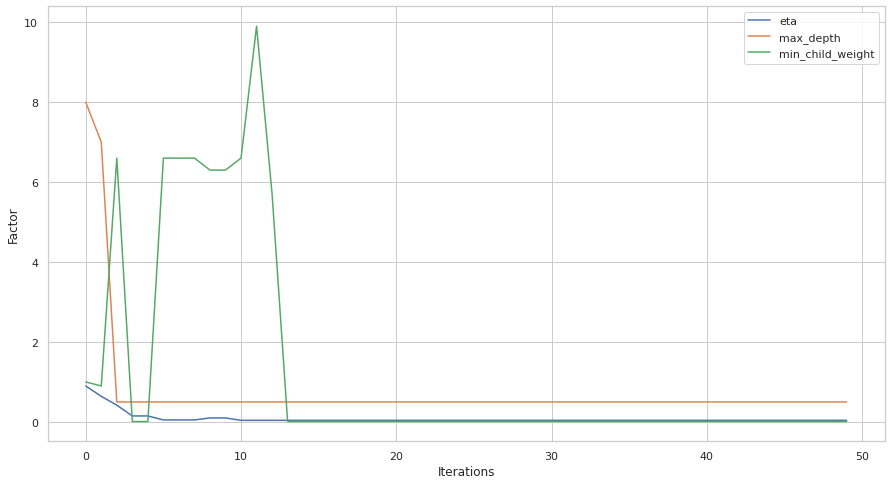

In [182]:
if calculate_weights and madrid:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

- [Bayesian Optimization with HYPEROPT](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)

#### Carga hiperparámetros

In [183]:
if not calculate_weights:

    FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"

    best_hyperparams = load_json(HYPERPARAMS_PATH, FILE_NAME)

# # # 0.875 GA
# # # 0.04, 1, 3.9, 900
# # # best_hyperparams = {}
# # # best_hyperparams['eta'] = 0.04
# # # best_hyperparams['max_depth'] = 1
# # # best_hyperparams['min_child_weight'] = 3.9
# # # best_hyperparams['n_estimators'] = 900

#### Escritura hiperparámetros

In [184]:
if calculate_weights and madrid:
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, HYPERPARAMS_PATH, FILE_NAME)
    print(best_hyperparams)

{'eta': 0.039999999999999966, 'max_depth': 1.0, 'min_child_weight': 0.01}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [185]:
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'
# # FILE_NAME = 'madrid_weights_no_roadClass.json'
FILE_NAME = f"{city_name}_weights{loaded_timestamp}.json"

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

########## 17-05-2022 ##########
# Se ha cambiado 1stRoadClass (distrito) a RoadwayFeatures --> EN LEEDS NO ES ASÍ, PERO PARA Mí TIENE SENTIDO
# Se ha cambiado tipo accidente de RoadwayFeatures a Accident --> EN LEEDS NO EXISTE ESTE CAMPO, PERO PARA Mí TIENE SENTIDO
# feature_vector = {'Accident Features': {'feature_childs': ['coordenada_x_utm',
#    'coordenada_y_utm',
#    'hora',
#    'vehiculos_implicados',
#    'tipo_accidente'],
#   'feature_weights': ['0.03979435',
#    '0.061120145',
#    '0.02675103',
#    '0.083673365',
#    '0.03753465'],
#   'wpi': 0.255731688},
#  'Roadway Features': {'feature_childs': ['distrito', 'tipo_carretera'],
#   'feature_weights': ['0.044392798', '9999.9'],
#   'wpi': 0.03753465},
#  'Environmental Features': {'feature_childs': ['estado_meteorológico'],
#   'feature_weights': ['0.024665328'],
#   'wpi': 0.024665328},
#  'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
#   'feature_weights': ['0.048645806'],
#   'wpi': 0.048645806},
#  'Casualty Features': {'feature_childs': ['tipo_persona',
#    'sexo',
#    'rango_edad',
#    'drogas_alcohol_positivo'],
#   'feature_weights': ['0.2764425', '0.2201619', '0.06879471', '0.03230864'],
#   'wpi': 0.59770775}}


#### Cálculo de pesos de caracetrísticas

In [186]:
if calculate_weights and madrid:
    xgboost = XGBClassifier(best_hyperparams,
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


#### Visualización pesos calculados

{'hora': 962.0, 'tipo_carretera': 836.0, 'distrito': 989.0, 'tipo_accidente': 1009.0, 'estado_meteorológico': 459.0, 'tipo_vehiculo': 778.0, 'tipo_persona': 1128.0, 'rango_edad': 1170.0, 'sexo': 743.0, 'drogas_alcohol_positivo': 241.0, 'vehiculos_implicados': 1016.0, 'coordenada_x_utm': 1030.0, 'coordenada_y_utm': 999.0}
[0.05749885 0.11698669 0.05990374 0.06777608 0.05159172 0.06810846
 0.16769439 0.05199301 0.11149791 0.05437132 0.05197439 0.07549343
 0.06511011]
hora 0.057498846
tipo_carretera 0.11698669
distrito 0.05990374
tipo_accidente 0.06777608
estado_meteorológico 0.051591717
tipo_vehiculo 0.06810846
tipo_persona 0.16769439
rango_edad 0.05199301
sexo 0.11149791
drogas_alcohol_positivo 0.054371316
vehiculos_implicados 0.051974386
coordenada_x_utm 0.075493425
coordenada_y_utm 0.06511011


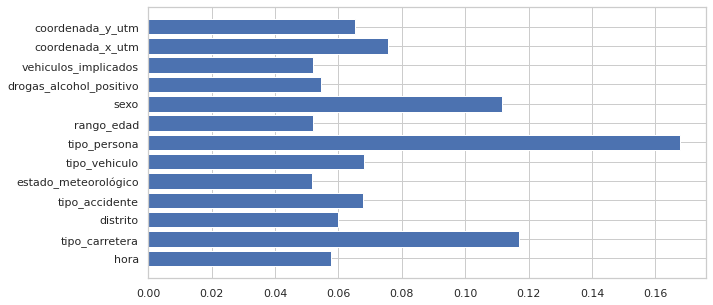

In [187]:
if calculate_weights and madrid:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train_downsampled.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    print(xgboost.feature_importances_)

    for column, weight in zip(X_train_downsampled.columns,xgboost.feature_importances_):
      print(column, weight)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train_downsampled, child_weights)

#### Escritura de pesos de características

- v5: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades no están en rango.
- v6: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades están en rango.
- v7: hiperparams, tipos de carretera tipificados por vía.

In [188]:
if calculate_weights and madrid:
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'default_calculated_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

In [189]:
feature_vector

{'Accident Features': {'feature_childs': ['coordenada_x_utm',
   'coordenada_y_utm',
   'hora',
   'vehiculos_implicados',
   'tipo_accidente'],
  'feature_weights': ['0.075493425',
   '0.06511011',
   '0.057498846',
   '0.051974386',
   '0.06777608'],
  'wpi': 0.317852847},
 'Roadway Features': {'feature_childs': ['distrito', 'tipo_carretera'],
  'feature_weights': ['0.05990374', '0.11698669'],
  'wpi': 0.17689043},
 'Environmental Features': {'feature_childs': ['estado_meteorológico'],
  'feature_weights': ['0.051591717'],
  'wpi': 0.051591717},
 'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
  'feature_weights': ['0.06810846'],
  'wpi': 0.06810846},
 'Casualty Features': {'feature_childs': ['tipo_persona',
   'sexo',
   'rango_edad',
   'drogas_alcohol_positivo'],
  'feature_weights': ['0.16769439', '0.11149791', '0.05199301', '0.054371316'],
  'wpi': 0.385556626}}

### Cálculo índices de matriz

In [190]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [191]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
train_original_bgi = build_gray_images(X_train_original, 5, matrix_indexes)

test_bgi  = build_gray_images(X_test, 5, matrix_indexes)

pd.DataFrame(train_bgi[:,:,1057])

127526
43603
10901


,0,1,2,3,4
0,0.000000,0.000000,-0.089487,0.000000,0.000000
1,-0.730298,-0.435205,0.133552,-0.168349,-0.100523
2,-0.059509,1.700585,0.213409,0.133407,0.000000
3,0.000000,-1.708296,0.502814,0.000000,0.000000
4,0.000000,0.000000,-0.223098,0.000000,0.000000


## Reshape de imágenes

In [192]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)

train_original_images = shape_images(X_data = X_train_original,
                                     gray_images = train_original_bgi)

test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)

/tmp/ipykernel_98712/3058630219.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


<Figure size 432x288 with 0 Axes>

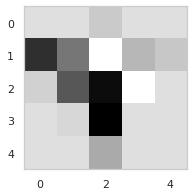

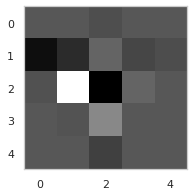

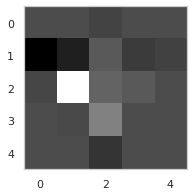

In [193]:
sns.set_theme(style="whitegrid")
plt.gray()
for i in range(100,103):
    plt.figure(figsize=(3, 3))
    plt.grid(b=None)
    plt.imshow(train_bgi[:,:,i])
    # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
    plt.show()

In [194]:
# train_images = shape_images(X_data = X_train,
#                             gray_images = train_bgi)
# test_images  = shape_images(X_data = X_test,
#                             gray_images = test_bgi)

## Visualización de datos

In [195]:
# !conda install -c anaconda seaborn --y

### Matriz de correlación

In [196]:
# correlation_matrix(data_frame)

### PCA

In [197]:
# pca(X_train, X_test)

In [198]:
MODEL_TIMESTAMP

'2022-05-19-18:20:01'

### TSNE

In [199]:
n_samples = 150
index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [200]:
# Get same number of class samples from SMOTEII
X_slight_train_tsne  = X_train.loc[index_slight]
X_serious_train_tsne = X_train.loc[index_serious]
X_fatal_train_tsne   = X_train.loc[index_fatal]

X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

Y_slight_train_tsne  = Y_train[index_slight]
Y_serious_train_tsne = Y_train[index_serious]
Y_fatal_train_tsne   = Y_train[index_fatal]

Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [201]:
n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [202]:
# Get same number of class samples from original
X_slight_clean_tsne  = X_train_original.loc[index_slight]
X_serious_clean_tsne = X_train_original.loc[index_serious]
X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

Y_slight_clean_tsne  = Y_train_original[index_slight]
Y_serious_clean_tsne = Y_train_original[index_serious]
Y_fatal_clean_tsne   = Y_train_original[index_fatal]

Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [203]:
if tsne:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [204]:
# # input_img = Input(shape=(25,))

# # # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
# # encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
# # encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

# # # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
# # decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
# # decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

# # # this model maps an input to its reconstruction
# # autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
# # autoencoder.summary()

# # autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas

# X_train = array_train_images
# X_test = array_test_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder.fit(X_train, X_train,
#                 epochs=120,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [205]:
# # create encoder model
# encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# # color=['red','green','blue']

# # for x, y, z, label in zip(xs, ys, zs, Y_test):
# #     c = color[int(label)]
# #     ax.text(x, y, z, label, backgroundcolor=c)
    
# # ax.set_xlim(xs.min(), xs.max())
# # ax.set_ylim(ys.min(), ys.max())
# # ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [206]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
Y_test_onehot  = casualty_to_one_hot(Y_test)

array_train_images = np.asarray(train_images)
array_train_original_images = np.asarray(train_original_images)
array_test_images  = np.asarray(test_images)

/tmp/ipykernel_98712/3907942643.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_labels.replace(transf, inplace = True)


## Models

In [207]:
array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

input_train_shape = (len(array_train_images), 5, 5, 1)
input_test_shape  = (len(array_test_images), 5, 5, 1)

array_train_images = array_train_images.reshape(input_train_shape)
array_test_images  = array_test_images.reshape(input_test_shape)

Y_test_labels = one_hot_to_casualty(Y_test)

from sklearn.utils import class_weight

pesos = class_weight.compute_class_weight('balanced',
                                          classes = np.unique(Y_train_original),
                                          y = Y_train_original)


print('\nPesos calculados:', pesos, '\n\n')


# Keras espera un diccionario donde la clave sea el número de clase 
# y el valor sea el peso calculado. 
pesos = dict(enumerate(pesos))  


Pesos calculados: [  0.34191191  14.1798374  210.64251208] 




In [208]:
import pickle
from joblib import dump, load

times = pd.DataFrame()

### NB

In [209]:
MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#### Entrenamiento

In [210]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = times.append(model_time)


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

#### Escritura del modelo

In [211]:
if city and train_nn and other_models:

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [212]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

FileNotFoundError: [Errno 2] No such file or directory: 'Models/nb/madrid_nb_2022-05-19-18:20:01.joblib'

#### Resultados

In [ ]:
if city:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### SVC

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"
MODEL_NAME = MODELS_NAME[4]

In [ ]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = times.append(model_time)

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

#### Escritura del modelo

In [ ]:
if city and train_nn and other_models:

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[0]

#### Entrenamiento

In [ ]:
knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

start = time.time()

knn.fit(X_train, Y_train)

end = time.time()

ellapsed_time = round(end - start, 2)

model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
times = times.append(model_time)

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [ ]:
# if city and train_nn and other_models:

#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#     dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [ ]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 1D

In [ ]:
MODEL_NAME = MODELS_NAME[1]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [ ]:
if city and train_nn:
    start = time.time()

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                 # class_weight = pesos,
                                 batch_size = 128,
                                 epochs = 100,
                                 shuffle = True,
                                 validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = times.append(model_time)

    history

#### Escritura del modelo

In [ ]:
if city and train_nn:

    convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and not laptop:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [ ]:
MODEL_NAME = MODELS_NAME[2]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-19-06:33:55.h5'

#### Entrenamiento

In [ ]:
if city and train_nn:

    start = time.time()

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                       # class_weight = pesos,
                       batch_size = 128,
                       epochs = 100,
                       shuffle = True,
                       validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = times.append(model_time)    

    history

#### Escritura del modelo

In [ ]:
if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [ ]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [ ]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [ ]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

In [ ]:
if city and not laptop:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


## AutoML

In [ ]:
MODEL_NAME = MODELS_NAME[3]

In [ ]:
# tasp_cnn.save(root_path + 'madrid_model_XGBOOST_predicted.h5')

In [ ]:
# import autokeras as ak

# # clf = ak.ImageClassifier(num_classes = 3,
# #                          loss='categorical_crossentropy',
# #                          metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
# #                          overwrite = True,
# #                          tuner= 'bayesian',
# #                          max_trials = 20,
# #                          max_model_size = 3000000
# #                         )
# clf = ak.StructuredDataClassifier(num_classes = 3,
#                              loss='categorical_crossentropy',
#                              metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
#                              overwrite = True,
#                              tuner= 'bayesian',
#                              max_trials = 20
#                         )

# clf.fit(array_train_images,
#         np.asarray(Y_train),
#         epochs = 100,
#         batch_size = 128,
#         validation_data = (array_test_images, np.asarray(Y_test)))

# best_auto_model = clf.export_model()
# print(best_auto_model.summary())

### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# best_auto_model.save(MODEL_PATH + MODEL_FILE_NAME)

### Resultados

In [ ]:
# Y_predicted = best_auto_model.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

# F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
# F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

# # plot_f1_score(f1_score_path = F1_SCORE_PATH,
# #               f1_score_name = F1_SCORE_NAME,
# #               history = history)

# print("[INFO] evaluating network...")

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# plot_classification_report(path = REPORT_PATH,
#                            file_name = REPORT_NAME,
#                            y_true = Y_test,
#                            y_predicted = Y_predicted)


# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

# plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
#                       file_name = CONFUSION_MATRIX_NAME,
#                       y_true = Y_test,
#                       y_predicted = Y_predicted)

# Data Summary

## Models times plot

### Sort

In [ ]:
times = times.sort_values('time')

### Save csv

In [ ]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [ ]:
# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [ ]:
from os.path import exists

reports_summary = pd.DataFrame()

cities = []

cities.append('leeds')  if leeds else None
cities.append('madrid') if madrid else None

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution',
                   'nb': 'NB',
                   'svc': 'SVC'}
                   # 'auto_ml': 'AutoML'}
splits = ['train', 'test']

sorted_by_time_models_name = times.model

for split in splits:
    reports_summary = pd.DataFrame()

    for model_name in sorted_by_time_models_name:

        REPORT_PATH = f"{REPORTS_PATH}{model_name}/{split}/"

        for city_name in cities:

            REPORT_NAME  = f"{city_name}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

            if exists(REPORT_PATH + REPORT_NAME):
                print(f"Found: {model_name} for {split}")
                report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
                report.insert(0, 'split', split)
                report.insert(1, 'city', city_name)
                report.insert(2, 'model', models_renaming[model_name])

                reports_summary = pd.concat([reports_summary, report])

                reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

    if not reports_summary.empty:
        c_m = reports_summary['city'] + '_' + reports_summary['model']
        reports_summary.insert(0, 'c_m', c_m)

        SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}/{split}/{MODEL_TIMESTAMP}.csv"

        reports_summary.insert(0, 'accident_type', reports_summary.index)
        reports_summary.to_csv(SAVE_PATH, index= True)

## Models scores plot

In [ ]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']



if leeds:
    leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

        if leeds:
            leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']

        for index, measure_type in enumerate(MEASURE_TYPES):

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axs[index]

            if leeds:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_leeds).set(title = f"{measure_type} Leeds")

            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        fig.savefig(SAVE_PATH)